This notebook serves as an example of how to load and manipulate the [COMP6 dataset](https://github.com/isayev/COMP6) using a `Dataset` object.

In [1]:
import os
import numpy as np

from ase import Atoms

# Initialize the database

In [2]:
from colabfit.tools.database import MongoDatabase, load_data

client = MongoDatabase('comp6', nprocs=6)#, drop=True)

# Setup

The COMP6 dataset is one of a collection of datasets that uses the [ANI-1 format](https://github.com/isayev/ANI1_dataset) for loading. Before running this example, you should make sure that [pyanitools.py](https://github.com/isayev/ANI1_dataset/blob/master/readers/lib/pyanitools.py) is in `PYTHONPATH` so that you can use it for loading from the ANI-formatted HDF5 files.

In [3]:
import sys

my_path_to_pyanitools = '../../../svreg_data/AlZnMg/AL_Al/'
sys.path.append(my_path_to_pyanitools)

# Custom reader

Since COMP6 is not stored in one of the core file formats, a user-specified `reader` function must be provided to `load_data` in order to read the data.

In [4]:
def reader(path):    
    import pyanitools as pya
    
    adl = pya.anidataloader(path)
    
    images = []
    for data in adl:        
        for i in range(data['coordinates'].shape[0]):
            atoms = Atoms(symbols=data['species'], positions=data['coordinates'][i])
            
            atoms.info['name'] = '{}_{}_conformer_{}'.format(os.path.split(path)[-1], data['path'], i)
            
            atoms.info['energy'] = data['energies'][i]
            atoms.arrays['forces'] = data['forces'][i]
            
            atoms.info['cm5'] = data['cm5'][i]
            atoms.info['hirdipole'] = data['hirdipole'][i]
            atoms.info['hirshfeld'] = data['hirshfeld'][i]
            atoms.info['spindensities'] = data['spindensities'][i]
            
            images.append(atoms)
            
    return images

# Data loading

In [5]:
comp6_property_definition = {
    'property-id': 'comp6-data',
    'property-title': 'cm5, hirdipole, hirshfeld, spindensities',
    'property-description': 'Charges, dipoles, and spin densities',
    'energy':       {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Configuration energy'},
    'forces':       {'type': 'float', 'has-unit': True, 'extent': [":", 3], 'required': True, 'description': 'Atomic forces'},
    'cm5':          {'type': 'float', 'has-unit': True, 'extent': [":"], 'required': True, 'description': 'CM5 atomic charges'},
    'hirshfeld':    {'type': 'float', 'has-unit': True, 'extent': [":"], 'required': True, 'description': 'Hirshfeld atomic charges'},
    'hirdipole':    {'type': 'float', 'has-unit': True, 'extent': [":", 3], 'required': True, 'description': 'Hirshfeld atomic dipoles'},
}

In [6]:
client.insert_property_definition(comp6_property_definition)

/home/jvita/scripts/colabfit-tools/colabfit/tools/database.py:554: UserWarning: Invalid KIM property-id; Temporarily renaming to tag:@,0000-00-00:property/comp6-data
  warnings.warn(f"Invalid KIM property-id; Temporarily renaming to {dummy_dict['property-id']}")


In [7]:
client.get_property_definition('comp6-data')

{'_id': 'comp6-data',
 'definition': {'property-id': 'comp6-data',
  'property-title': 'cm5, hirdipole, hirshfeld, spindensities',
  'property-description': 'Charges, dipoles, and spin densities',
  'energy': {'type': 'float',
   'has-unit': True,
   'extent': [],
   'required': True,
   'description': 'Configuration energy'},
  'forces': {'type': 'float',
   'has-unit': True,
   'extent': [':', 3],
   'required': True,
   'description': 'Atomic forces'},
  'cm5': {'type': 'float',
   'has-unit': True,
   'extent': [':'],
   'required': True,
   'description': 'CM5 atomic charges'},
  'hirshfeld': {'type': 'float',
   'has-unit': True,
   'extent': [':'],
   'required': True,
   'description': 'Hirshfeld atomic charges'},
  'hirdipole': {'type': 'float',
   'has-unit': True,
   'extent': [':', 3],
   'required': True,
   'description': 'Hirshfeld atomic dipoles'}}}

In [8]:
property_map = {
    'comp6-data': {
        # Property Definition field: {'field': ASE field, 'units': ASE-readable units}
        'energy':    {'field': 'energy',    'units': 'kcal/mol'},
        'forces':    {'field': 'forces',    'units': 'kcal/mol/Ang'},
        'cm5':       {'field': 'cm5',       'units': 'elementary_charge'},
        'hirshfeld': {'field': 'hirshfeld', 'units': 'elementary_charge'},
        'hirdipole': {'field': 'hirdipole', 'units': 'elementary_charge*Ang'},
    }
}

In [9]:
images = load_data(
    file_path='../../../colabfit/data/isayev/COMP6/COMP6v1/',
    file_format='folder',
    name_field='name',  # key in Configuration.info to use as the Configuration name
    elements=['C', 'H', 'N', 'O'],    # order matters for CFG files, but not others
    default_name='comp6',  # default name with `name_field` not found
    reader=reader,
    glob_string='*.h5',
    verbose=True
)

In [10]:
from colabfit.tools.property_settings import PropertySettings

pso = PropertySettings(
    method='Gaussian09',
    description='COMP6 property settings calculation',
    files=[],
    labels=['DFT', 'wb97x', '6-31G(d)'],
)

ids = client.insert_data(
    images,
    property_map=property_map,
    property_settings={'comp6-data': pso},
#     generator=False,
    verbose=True
)

Loading data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.89s/it]
/home/jvita/Programs/miniconda2/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
Adding configurations to Database: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 16892/16892 [00:33<00:00, 500.67it/s]


In [11]:
configuration_set_regexes = {
    'ani_md_bench':
        'Forces from the ANI-1x potential are applied to run '\
        '1 ns of vacuum molecular dynamics with a 0.25 fs time '\
        'step at 300 K using the Langevin thermostat on 14 well-'\
        'known drug molecules and two small proteins. System '\
        'sizes range from 20 to 312 atoms. A random subsample '\
        'of 128 frames from each 1 ns trajectory is selected, and '\
        'reference DFT single point calculations are performed '\
        'to obtain QM energies and forces.',
    'drugbank_testset':
        'This benchmark is developed '\
        'through a subsampling of the DrugBank database '\
        'of real drug molecules. 837 SMILES strings con'\
        'taining C, N, and O are randomly selected. Like the '\
        'GDB7to9 benchmark, the molecules are embedded in '\
        '3D space, structurally optimized, and normal modes are '\
        'computed. DNMS is utilized to generate random '\
        'non-equilibrium conformations.',
    'gdb11_0[7-9]':
        'The GDB-11 subsets contain'\
        'ing 7 to 9 heavy atoms (C, N, and O) are subsampled '\
        'and randomly embedded in 3D space using RDKit '\
        '[www.rdkit.org]. A total of 1500 molecule SMILES '\
        '[opensmiles.org] strings are selected: 500 per 7, 8, '\
        'and 9 heavy-atom sets. The resulting structures are '\
        'optimized with tight convergence criteria, and nor'\
        'mal modes/force constants are computed using the '\
        'reference DFT model. Finally, diverse normal mode '\
        'sampling (DNMS) is carried out to generate non-'\
        'equilibrium conformations.',
    'gdb1[1,3]_1[0-3]':
        'GDB10to13 benchmark. Subsamples of 500 SMILES '\
        'strings each from the 10 and 11 heavy-atom subsets '\
        'of GDB-11 and 1000 SMILES strings from the 12 '\
        'and 13 heavy-atom subsets of the GDB-13 database '\
        'are randomly selected. DNMS is utilized to generate '\
        'random non-equilibrium conformations.',
    'tripeptide_full':
        'Tripeptide benchmark. 248 random tripeptides contain'\
        'ing H, C, N, and O are generated using FASTA strings '\
        'and randomly embedded in 3D space using RDKit. As '\
        'with GDB7to9, the molecules are optimized, and nor'\
        'mal modes are computed. DNMS is utilized to generate '\
        'random non-equilibrium conformations.',
    's66x8_wb97x6-31gd':
        'S66x8 benchmark. This dataset is built from the '\
        'original S66x850 benchmark for comparing accuracy '\
        'between different methods in describing noncovalent '\
        'interactions common in biological molecules. S66x8 is '\
        'developed from 66 dimeric systems involving hydro'\
        'gen bonding, pi-pi stacking, London interactions, and '\
        'mixed influence interactions. While the keen reader '\
        'might question the use of this benchmark without dis'\
        'persion corrections, since dispersion corrections such '\
        'as the D362 correction by Grimme et al. are a posteriori '\
        'additions to the produced energy, then a comparison '\
        'without the correction is equivalent to a comparison '\
        'with the same dispersion corrections applied to both '\
        'models.'
}

In [12]:
cs_ids = []

for i, (regex, desc) in enumerate(configuration_set_regexes.items()):
    co_ids = client.get_data(
        'configurations',
        fields='_id',
        query={'names': {'$regex': regex}}
    )
    
    print(f'Configuration set {i}', f'({regex}):'.rjust(20), f'{len(co_ids)}'.rjust(7))

    cs_id = client.insert_configuration_set(co_ids, description=desc, verbose=True)
    
    cs_ids.append(cs_id)

Database 0      (ani_md_bench):    1791


Aggregating configuration info: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1791/1791 [00:00<00:00, 5485.96it/s]


Database 1  (drugbank_testset):   13379


Aggregating configuration info: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 13379/13379 [00:02<00:00, 6676.94it/s]


Database 2      (gdb11_0[7-9]):   36000


Aggregating configuration info: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 36000/36000 [00:04<00:00, 8439.88it/s]


Database 3  (gdb1[1,3]_1[0-3]):   47670


Aggregating configuration info: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 47670/47670 [00:06<00:00, 7841.23it/s]


Database 4   (tripeptide_full):    1984


Aggregating configuration info: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1984/1984 [00:00<00:00, 6398.62it/s]


Database 5 (s66x8_wb97x6-31gd):     528


Aggregating configuration info: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 528/528 [00:00<00:00, 7790.51it/s]


In [13]:
pr_ids = client.get_data('properties', fields='_id')
len(pr_ids)

101352

In [14]:
ds_id = client.insert_dataset(
    cs_ids=cs_ids,
    pr_ids=pr_ids,
    authors=[
        'Justin S. Smith',
        'Ben Nebgen',
        'Nicholas Lubbers',
        'Olexandr Isayev',
        'Adrian E. Roitberg'
    ],
    links=[
        'https://aip.scitation.org/doi/full/10.1063/1.5023802',
        'https://github.com/isayev/COMP6',
    ],
    description='This repository contains the COMP6 benchmark '\
        'for evaluating the extensibility of machine-learning '\
        'based molecular potentials.',
    resync=True,
    verbose=True,
)

Updating PR->DS relationships: 100%|████████████████████████████████████████████████████████████████████████████████████████| 101352/101352 [00:00<00:00, 232841.01it/s]


In [3]:
ds_id = '-2634076948133108791'
ds = client.get_dataset(ds_id, verbose=True)['dataset']

In [4]:
for k,v in ds.aggregated_info.items():
    print(k, v)

nconfigurations 101352
nsites 2608858
nelements 4
elements ['C', 'H', 'N', 'O']
individual_elements_ratios [[0.28, 0.48, 0.26, 0.31, 0.34, 0.29, 0.33, 0.43, 0.38, 0.35, 0.25, 0.42, 0.5, 0.18, 0.6, 0.11, 0.27, 0.52, 0.44, 0.19, 0.36, 0.53, 0.45, 0.2, 0.37, 0.12, 0.23, 0.54, 0.21, 0.22, 0.17, 0.46, 0.15, 0.1, 0.16, 0.13, 0.3, 0.47, 0.55, 0.8, 0.39, 0.14, 0.08, 0.56, 0.4, 0.57, 0.32, 0.24, 0.49, 0.41], [0.44, 0.55, 0.53, 0.43, 0.42, 0.4, 0.56, 0.58, 0.38, 0.54, 0.5, 0.59, 0.67, 0.25, 0.34, 0.51, 0.26, 0.6, 0.35, 0.68, 0.11, 0.52, 0.27, 0.69, 0.36, 0.61, 0.7, 0.45, 0.2, 0.62, 0.37, 0.12, 0.29, 0.23, 0.22, 0.21, 0.17, 0.71, 0.46, 0.63, 0.3, 0.47, 0.64, 0.39, 0.31, 0.48, 0.57, 0.65, 0.32, 0.49, 0.41, 0.66, 0.33], [0.18, 0.07, 0.13, 0.14, 0.2, 0.33, 0.12, 0.31, 0.26, 0.06, 0.25, 0.42, 0.5, 0.43, 0.35, 0.11, 0.05, 0.27, 0.19, 0.44, 0.36, 0.04, 0.28, 0.45, 0.29, 0.22, 0.1, 0.15, 0.17, 0.09, 0.16, 0.03, 0.21, 0.23, 0.38, 0.46, 0.3, 0.02, 0.39, 0.08, 0.57, 0.01, 0.32, 0.24], [0.06, 0.07, 0.13, 0.

# Exploration

In [5]:
ds.aggregated_info['property_fields']

['comp6-data.energy',
 'comp6-data.forces',
 'comp6-data.cm5',
 'comp6-data.hirshfeld',
 'comp6-data.hirdipole']

In [19]:
from IPython.display import Image

In [7]:
fig = client.plot_histograms(ds.aggregated_info['property_fields'], verbose=True)

Getting data: 101352it [00:01, 65015.62it/s]
Getting data: 101352it [00:05, 17103.47it/s]
Getting data: 101352it [00:01, 58061.40it/s]
Getting data: 101352it [00:01, 56407.28it/s]
Getting data: 101352it [00:06, 16806.42it/s]


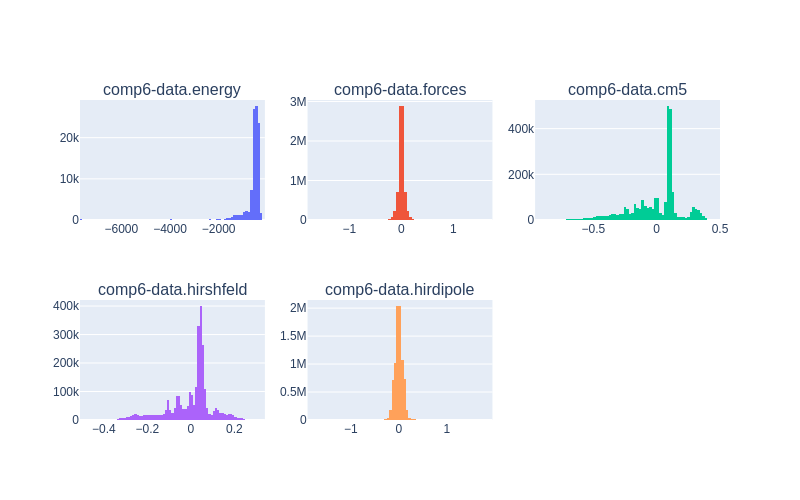

In [9]:
Image(fig.to_image(format="png", width=800, height=500, scale=1))

In [12]:
energies = client.get_data('properties', 'comp6-data.energy', ravel=True)

In [13]:
sum(energies < -4000)

128

In [15]:
clean_config_sets, clean_property_ids = client.filter_on_properties(
    ds_id=ds_id,
#     lambda p: p['energy']['source-value'] > -4000,
    filter_fxn=lambda p: p['comp6-data']['energy']['source-value'] > -4000,
    fields=['comp6-data.energy'],
    verbose=True
)

Filtering on properties: 101352it [00:01, 69399.32it/s]
Aggregating configuration info: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 528/528 [00:00<00:00, 3683.23it/s]


In [18]:
len(clean_config_sets)

6

In [21]:
clean_cs_ids = []

for cs in clean_config_sets:
    cs_id = client.insert_configuration_set(cs.configuration_ids, description=cs.description, verbose=True)
    
    clean_cs_ids.append(cs_id)

In [22]:
ds.authors

['Justin S. Smith',
 'Ben Nebgen',
 'Nicholas Lubbers',
 'Olexandr Isayev',
 'Adrian E. Roitberg']

In [24]:
clean_ds_id = client.insert_dataset(
    cs_ids=clean_cs_ids,
    pr_ids=clean_property_ids,
    authors=ds.authors,
    links=ds.links,
    description="A filtered version of the COMP6 dataset "\
    "that removed all configurations with energies < -4000",
    resync=True,
    verbose=True
)

In [3]:
clean_ds_id = '4258247112410993928'
clean_ds = client.get_dataset(clean_ds_id, verbose=True)['dataset']

In [28]:
fig = client.plot_histograms(clean_ds.aggregated_info['property_fields'], ids=clean_ds.property_ids, verbose=True)

Getting data: 101224it [00:01, 57047.02it/s]
Getting data: 101224it [00:06, 15222.94it/s]
Getting data: 101224it [00:02, 44191.91it/s]
Getting data: 101224it [00:02, 45682.27it/s]
Getting data: 101224it [00:06, 14675.72it/s]


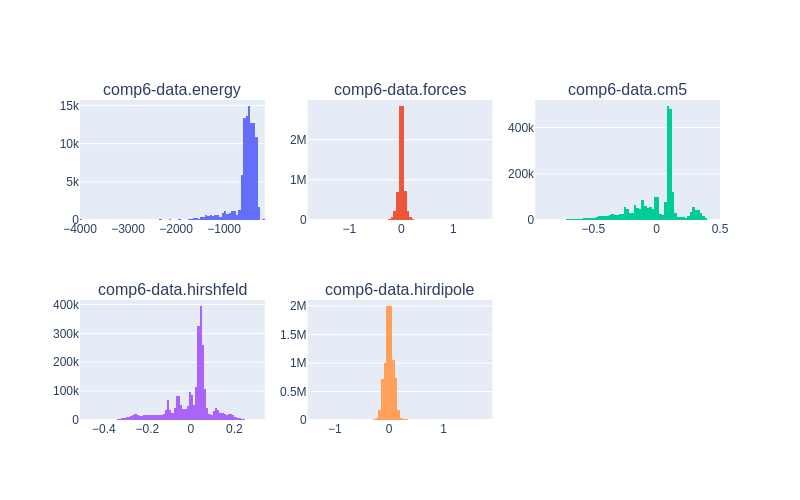

In [29]:
Image(fig.to_image(format="png", width=800, height=500, scale=1))

## Extracting data from Configuration Sets

In [4]:
config_sets = [
    client.get_configuration_set(csid)['configuration_set']
    for csid in clean_ds.configuration_set_ids
]

In [5]:
ids = client.get_data('configurations', fields='_id', ids=config_sets[0].configuration_ids, ravel=True)
len(ids)

1984

In [7]:
client.get_data('configurations', fields='_id', ids=config_sets[0].configuration_ids, concatenate=True)

array(['-1013090799371865130', '-1035491155181520587',
       '-1038975143060528401', ..., '984284735128933662',
       '98844755940012527', '989036677302673811'], dtype='<U20')

In [15]:
batched_property_ids = [
    client.get_data('configurations', fields='relationships.properties', ids=cs.configuration_ids, ravel=True)
    for cs in config_sets
]

In [16]:
batched_property_ids[0][:10].tolist()

['1857369971683920165',
 '-3669025088180982856',
 '5976632754097006425',
 '7802911299350440902',
 '9135573067753407722',
 '-8455889225344689099',
 '-7076777093090633002',
 '-7666032656680489543',
 '9164302053622280413',
 '3120288936808100477']

Getting data: 1984it [00:00, 25228.36it/s]
Getting data: 1984it [00:00, 8605.05it/s]
Getting data: 1984it [00:00, 27205.02it/s]
Getting data: 1984it [00:00, 34323.39it/s]
Getting data: 1984it [00:00, 7674.12it/s]


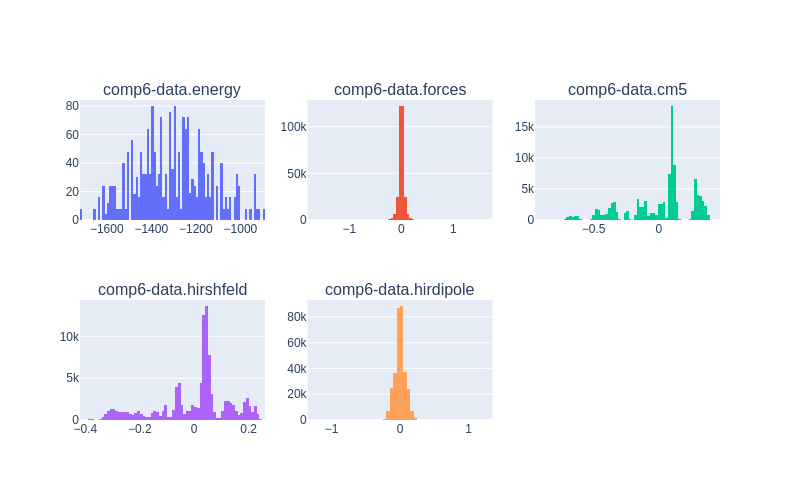

In [21]:
fig = client.plot_histograms(
    clean_ds.aggregated_info['property_fields'],
    ids=batched_property_ids[0],
    verbose=True
)

Image(fig.to_image(format="png", width=800, height=500, scale=1))

Getting data: 36000it [00:00, 49581.58it/s]
Getting data: 36000it [00:01, 19660.10it/s]
Getting data: 36000it [00:00, 44749.77it/s]
Getting data: 36000it [00:00, 43842.59it/s]
Getting data: 36000it [00:01, 19391.96it/s]


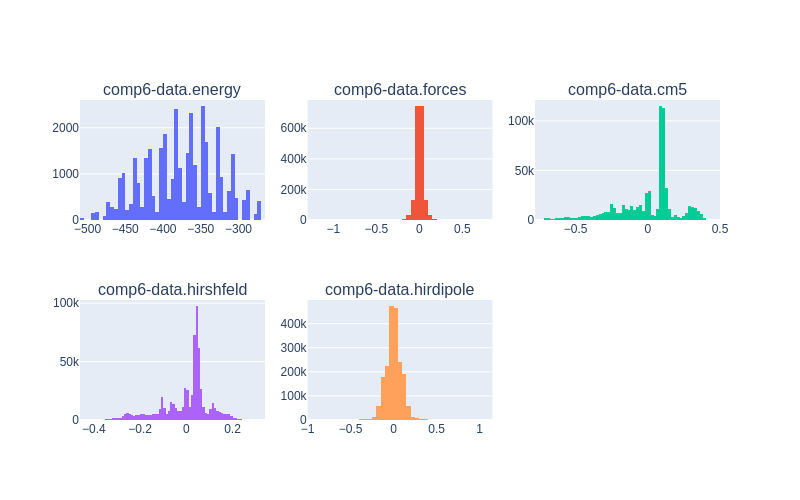

In [22]:
fig = client.plot_histograms(
    clean_ds.aggregated_info['property_fields'],
    ids=batched_property_ids[1],
    verbose=True
)

Image(fig.to_image(format="png", width=800, height=500, scale=1))

Getting data: 1663it [00:00, 29581.20it/s]
Getting data: 1663it [00:00, 8714.47it/s]
Getting data: 1663it [00:00, 19287.65it/s]
Getting data: 1663it [00:00, 19007.09it/s]
Getting data: 1663it [00:00, 6023.37it/s]


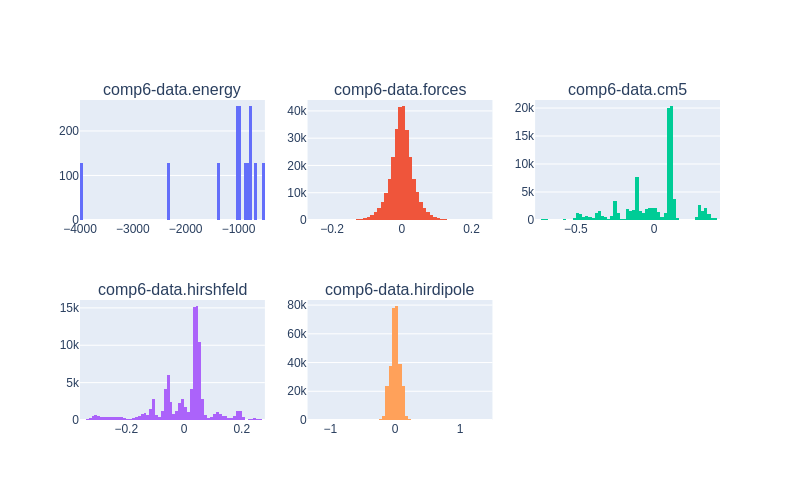

In [23]:
fig = client.plot_histograms(
    clean_ds.aggregated_info['property_fields'],
    ids=batched_property_ids[2],
    verbose=True
)

Image(fig.to_image(format="png", width=800, height=500, scale=1))

Getting data: 47670it [00:00, 49797.78it/s]
Getting data: 47670it [00:02, 16234.45it/s]
Getting data: 47670it [00:01, 41179.26it/s]
Getting data: 47670it [00:01, 39959.64it/s]
Getting data: 47670it [00:02, 16094.11it/s]


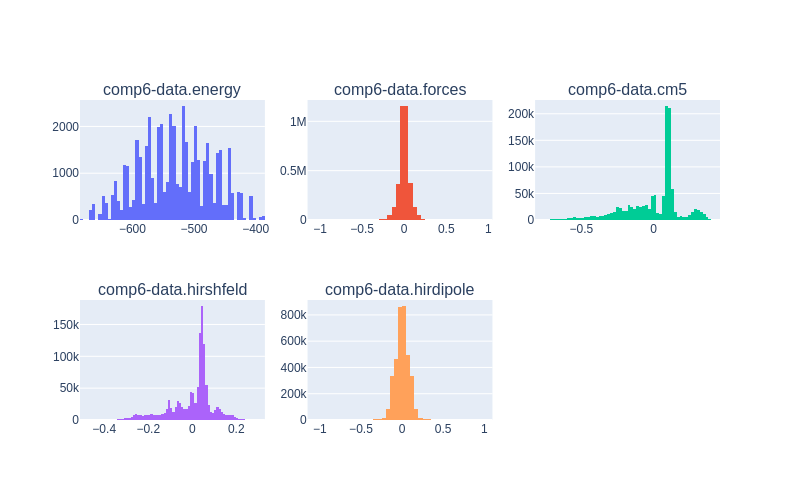

In [24]:
fig = client.plot_histograms(
    clean_ds.aggregated_info['property_fields'],
    ids=batched_property_ids[3],
    verbose=True
)

Image(fig.to_image(format="png", width=800, height=500, scale=1))

Getting data: 13379it [00:00, 41077.55it/s]
Getting data: 13379it [00:01, 10172.74it/s]
Getting data: 13379it [00:00, 37587.05it/s]
Getting data: 13379it [00:00, 33157.68it/s]
Getting data: 13379it [00:01, 10706.56it/s]


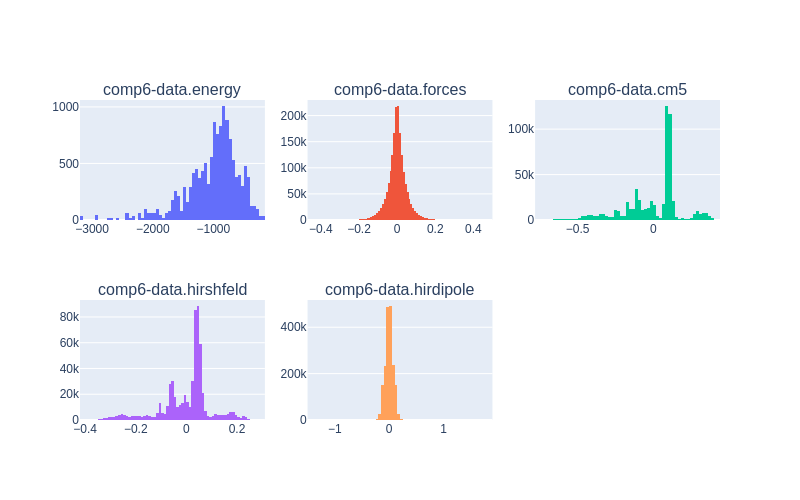

In [25]:
fig = client.plot_histograms(
    clean_ds.aggregated_info['property_fields'],
    ids=batched_property_ids[4],
    verbose=True
)

Image(fig.to_image(format="png", width=800, height=500, scale=1))

Getting data: 528it [00:00, 42830.47it/s]
Getting data: 528it [00:00, 23389.55it/s]
Getting data: 528it [00:00, 42415.39it/s]
Getting data: 528it [00:00, 44266.18it/s]
Getting data: 528it [00:00, 9239.56it/s]


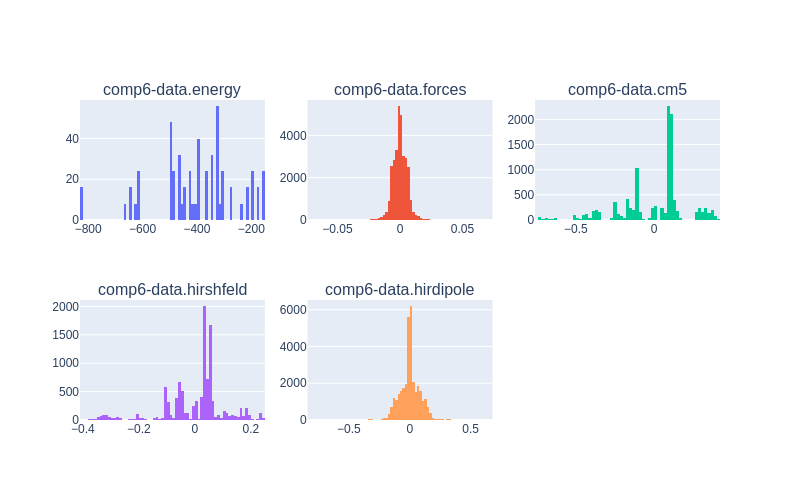

In [26]:
fig = client.plot_histograms(
    clean_ds.aggregated_info['property_fields'],
    ids=batched_property_ids[5],
    verbose=True
)

Image(fig.to_image(format="png", width=800, height=500, scale=1))